# ВЫПОЛНЕНИЕ ПРОЕКТА
---

## Шаг 1. Загрузка данных

Для начала импортируем необходимые библиотеки, модули и классы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

Получим данные и посмотрим описание датафрема, а также выведем первые 5 строк.

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB
None


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Пропусков нет, тип данных соответствует значениям, временной ряд отсутствует.

Любопытно, но в столбце ***Month_to_end_contract*** тип даных *float*, однако значения не содержат дробной части. Проверм, применимо ли это ко всему столбцу.

In [3]:
df['Month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

Да, так и есть. Преобразуем тип данных в *int* и проверим результат.

In [4]:
df['Month_to_end_contract'] = df['Month_to_end_contract'].astype('int64')
df['Month_to_end_contract'].unique()

array([ 5, 12,  1,  6,  3, 10, 11,  9,  4,  7,  8,  2], dtype=int64)

Теперь проверим дубликаты

In [5]:
df.duplicated().sum()

0

Дубликатов нет, замечательно.

## Шаг 2. Исследовательский анализ данных (EDA)

Изучим средние значения и стандартные отклонения для каждого признака.

In [6]:
print()
for column in df.drop('Churn', axis=1).columns:
    if df[column].unique().sum() == 1:
        print('Описание значений категориального признака', column)
    else:
        print('Описание значений признака', column)
    print()
    print('Среднее {:.4f}'.format(df[column].mean()))
    print('Стандартное отклонение {:.5f}'.format(df[column].std()))
    print('---------------------------------------')
    print()


Описание значений категориального признака gender

Среднее 0.5102
Стандартное отклонение 0.49996
---------------------------------------

Описание значений категориального признака Near_Location

Среднее 0.8452
Стандартное отклонение 0.36171
---------------------------------------

Описание значений категориального признака Partner

Среднее 0.4868
Стандартное отклонение 0.49989
---------------------------------------

Описание значений категориального признака Promo_friends

Среднее 0.3085
Стандартное отклонение 0.46193
---------------------------------------

Описание значений категориального признака Phone

Среднее 0.9035
Стандартное отклонение 0.29531
---------------------------------------

Описание значений признака Contract_period

Среднее 4.6813
Стандартное отклонение 4.54971
---------------------------------------

Описание значений категориального признака Group_visits

Среднее 0.4123
Стандартное отклонение 0.49230
---------------------------------------

Описание значений пр

Для не категориальных признаков слишком большой разброс - доверять среднему значению не приходится, т.к. стандартное отклонение зачастую примерно равно среднему, а иногда и выше него. Только с возрастом (`Age`) всё понятно.

Тоже самое применимо для категориальных признаков. Понятно только, что почти все оставили свой номер телефона (`Phone`) и у подавляющего большинства клиентов, фитнес-центр расположен поблизости (`Near_Location`).

Теперь рассмотрим средние значения признаков для группы оттока, и для тех кто остался.

In [7]:
display(df.groupby('Churn').agg('mean'))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Тут видно, что в группе оставшихся: 
- Зал чаще находится рядом с работой или домом - видимо, это мотивирует продолжать тренировки, т.к. они находятся рядом. Фактор "неохота добираться" не работает;
- Они чаще являются сотрудниками компании-партнёра клуба, и чаще использовали промо-код при оплате первого абонемента - предположу, что возможность держать себя в форме по выгодной цене оказалась более заманчива;
- Дольше посещали зал, относительно своего абонемента. То есть те кто ушёл, продержались не долго. В среднем, менее 2-х месяцев. Те кто остался, в среднем, посещают спортзал почти полгода. Видимо втянулись и дело вошло в режим. А может покинувшим просто не подошло или не понравилось.
- Чаще посещали групповые занятия - наверняка это заинтересовало их ещё больше и повысило результаты.
- Немного старше ушедших - может быть лучше осознают пользу тренировок, и в целом живут более размеренной жизнью, хотя разница по возрасту небольшая.
- Покупали больше дополнительных услуг фитнес-цетра - вероятно, им нравился сам процесс и услуги фитнес-центра.
- Оставалось больше времени до окончания абонемента. У ушедших оставалось меньше оплаченного времени, что наверняка помогло им махнуть рукой.
- Прошло больше времени с момента первого обращения в фитнес-центр - "вошли во вкус". Это схоже с другим признаком - временем, в течение которого клиенты посещали спортзал.
- Чаще посещают тренировки. В среднем, два раза в неделю. Ушедшие занимались примерно полтора раза в неделю, а в последний месяц 1 раз.

Построим графики распределения для имеющихся признаков у "оставшихся" и "ушедших" клиентов.  
Для начала отберём только те признаки, которые **не** представлены бинарно (0 и 1), то есть не категориальные.

In [8]:
a = []
for column in df.drop('Churn', axis=1).columns: 
    if df[column].unique().sum() != 1:
        a.append(column)

for i in a:
    print(i)

Contract_period
Age
Avg_additional_charges_total
Month_to_end_contract
Lifetime
Avg_class_frequency_total
Avg_class_frequency_current_month


Теперь построим графики для этих признаков. Для каждого, в разрезе оттока. На каждом графике, для наглядности, изобразим распределение для обеих групп (оставшиеся и ушедшие). Оставшихся отметим зелёным цветом, ушедших красным, прозрачность установим 0.6.

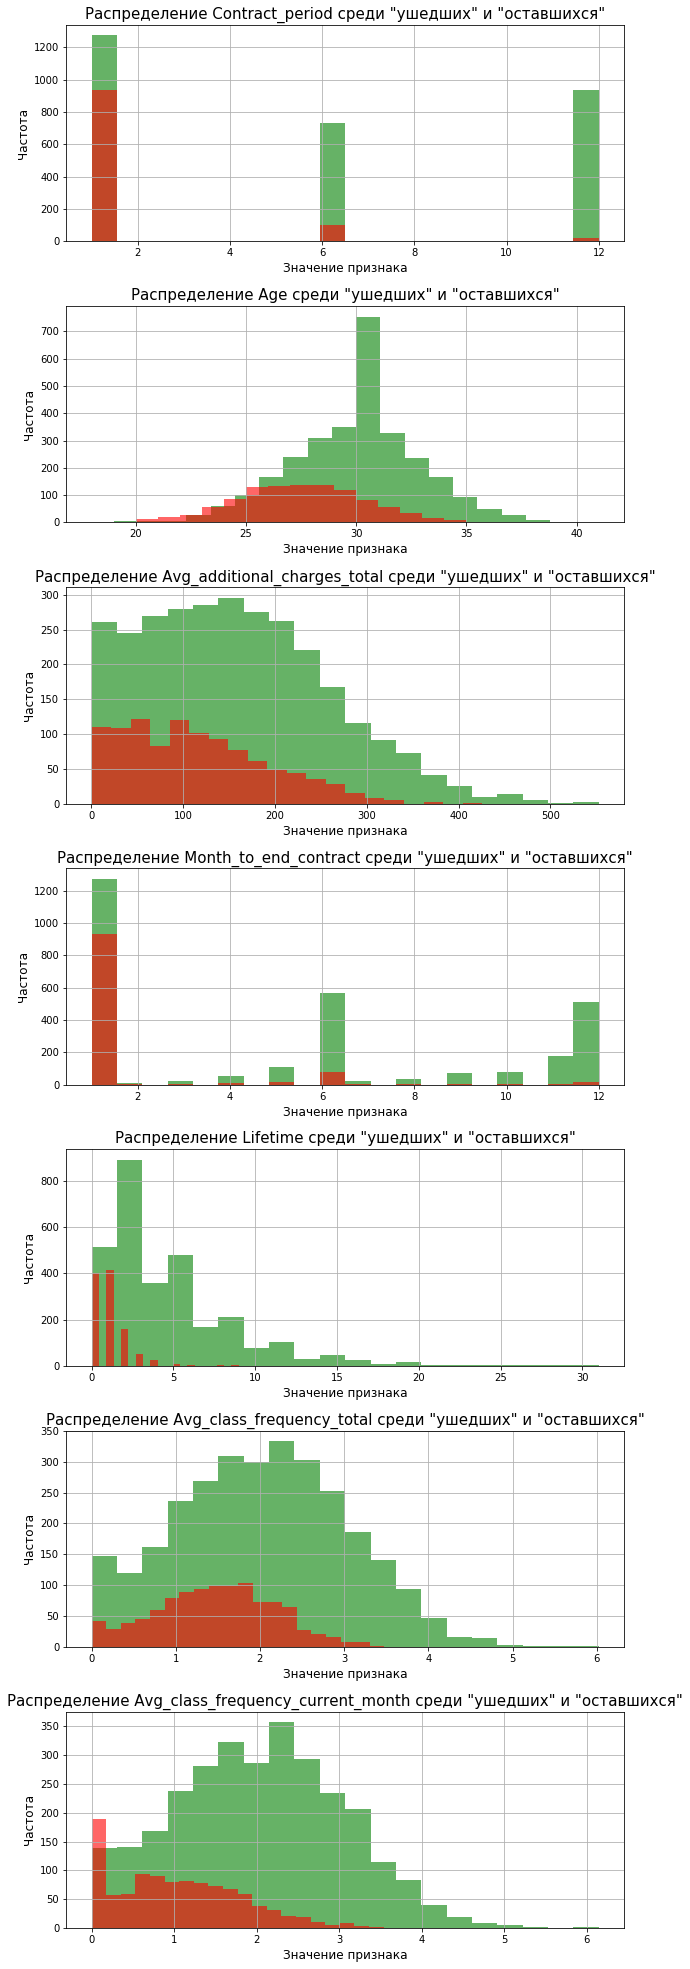

In [9]:
temp_list = [df[df['Churn'] == 0], df[df['Churn'] == 1]]
colors = ['green', 'red']

rows = 7
cols = 2
fig, axes = plt.subplots(rows, 1, figsize=(10, 35))
fig.subplots_adjust(hspace=0.3)

for row in range(rows):
    for col in range(cols):
        temp_list[col][a[row]].plot.hist(grid=True, bins=20, ax=axes[row], color=colors[col], alpha=0.6)
    axes[row].set_title('Распределение {} среди "ушедших" и "оставшихся"'.format(a[row]), fontsize=15)
    axes[row].set_ylabel('Частота', fontsize=12)
    axes[row].set_xlabel('Значение признака', fontsize=12)

Итого:
- Подавляющая часть ушедших клиентов заключала контракт на 1 месяц;
- Средний возраст у ушедших клиетов меньше чем у оставшихся;
- Ушедшие клиенты тратили меньше денег на дополнительные услуги;
- Подавляющая часть ушедших клиентов переставала посещать тренировки, когда до конца контракта с клубом оставался 1 месяц. Это пересекается с первым выводом. То есть клиенты приобретали контракт на 1 месяц и быстро переставали ходить в зал. Это подтверждает и распределение признака `Lifetime` - со времени первого обращения больше части ушедших клиентов в фитнес-центр прошло 1-2 месяца;
- Среднее количество тренировок в неделю у ушедших клиентов меньше чем у оставшихся, а в последни месяц ещё меньше.

Теперь построим аналогичные графики для остальных признаков, предварительно отобрав их.

In [10]:
b = []

for column in df.drop('Churn', axis=1).columns:
    if column not in a:
        b.append(column)
        
for i in b:
    print(i)

gender
Near_Location
Partner
Promo_friends
Phone
Group_visits


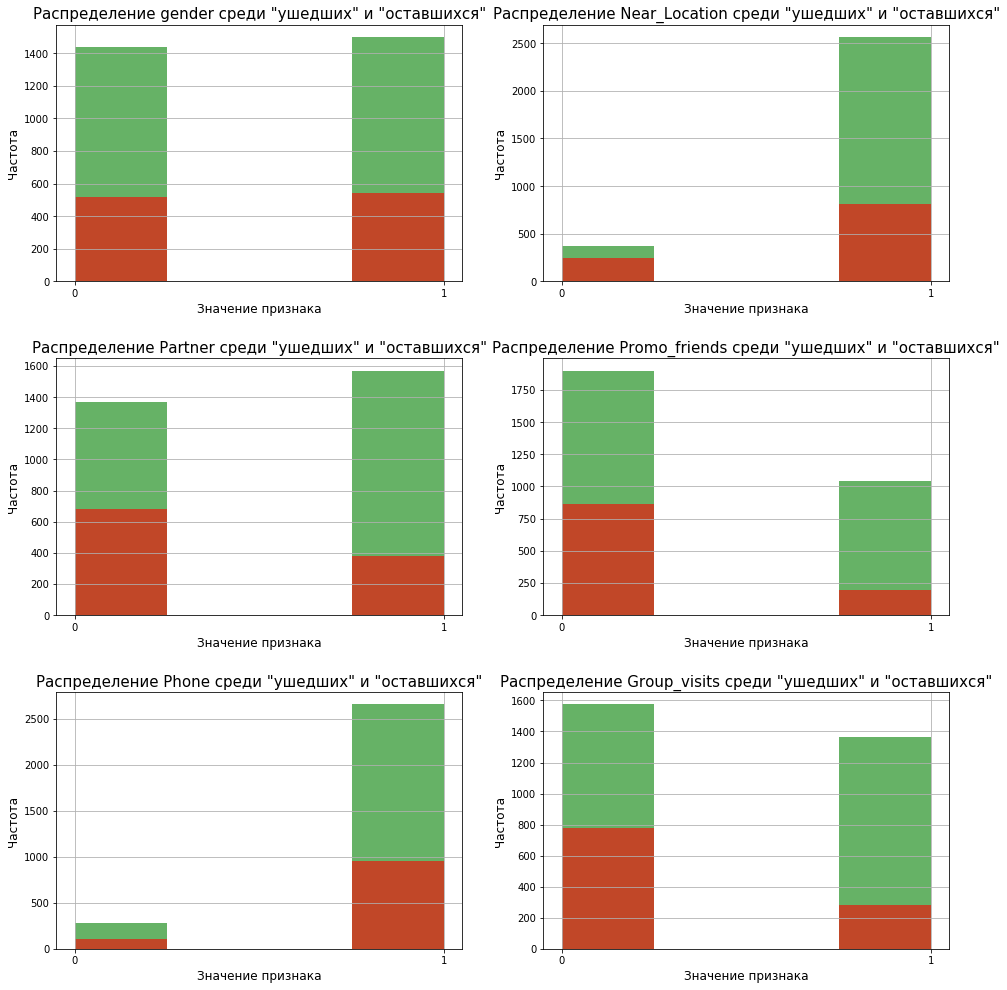

In [11]:
rows = 3
cols = 2
counter = 0
fig, axes = plt.subplots(rows, cols, figsize=(16, 17))
fig.subplots_adjust(hspace=0.3)

for row in range(rows):
    for col in range(cols):
        for i in range(0, 2):
            temp_list[i][b[counter]].plot.hist(grid=True, bins=4, ax=axes[row,col], color=colors[i], alpha=0.6)
        axes[row,col].set_title('Распределение {} среди "ушедших" и "оставшихся"'.format(b[counter]), fontsize=15)
        axes[row,col].set_ylabel('Частота', fontsize=12)
        axes[row,col].set_xlabel('Значение признака', fontsize=12)
        axes[row,col].set_xticks([0, 1])
        counter += 1

Выводы:
- Мужчин и женщин среди обеих групп примерно одинаковое количество;
- У подавляющей части оставшихся клиентов, фитнес-центр расположен поблизости, однако у большинства ушедших такая же ситуация. Скорее всего, для них этот фактор сработал на этапе покупки абонемента.
- Большая часть ушедших клиентов не была сотрудниками компании-партнёра клуба и не пришла в клуб по акции или промо-коду, в отличие от оставшихся.
- У клуба имелись номера телефонов больше части клиентов обеих групп.
- Ушедшие клиенты мало посещали групповые занятия.

Теперь, построим тепловую карту корреляции признаков.

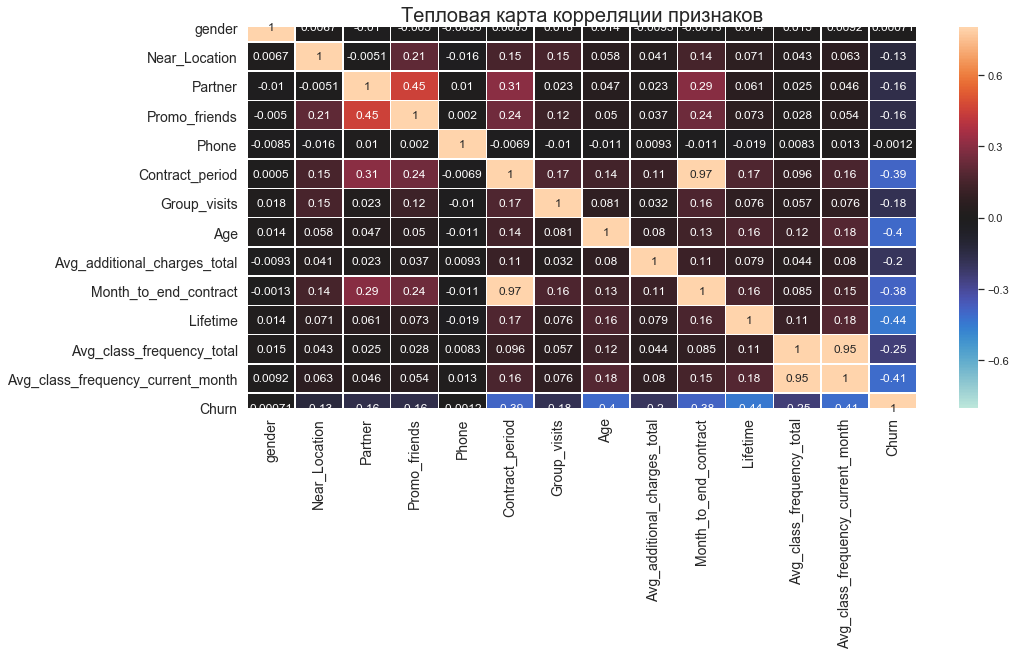

In [12]:
sns.set(style='white')
plt.figure(figsize=(15, 7))
plt.title('Тепловая карта корреляции признаков', fontsize=20)
sns.heatmap(data=df.corr(), 
            annot=True, 
            vmax=0.8, 
            vmin=-0.8, 
            linewidths=0.4, 
            linecolor='white', 
            center=0)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('')
plt.show()

По тепловой карте видно, что сильно коррелируют друг с другом 2 пары признаков. Это `Contract_period` и `Month_to_end_contract`, а так же `Avg_class_frequency_total` и `Avg_class_frequency_current_month`.

`Contract_period` и `Month_to_end_contract` взаимосвязаны, однако время, оставшееся до конца контракта, на момент прекращения тренировок, кажется более значимым.

Касаемо `Avg_class_frequency_total` и `Avg_class_frequency_current_month`, логичнее оставить второй признак, т.к. показатель активности в последний месяц может быть более важен, чем данные за всё время.

Таким образом, удалим столбцы `Contract_period` и `Avg_class_frequency_total` для корректного обучения модели.

### Шаг 3. Построение модели прогнозирования оттока клиентов

Удалим лишние признаки из таблицы, а также выделим вектор-столбец целевой переменной.  
Затем разделим данные на обучающую и валидационную (тестовую) выборки в пропорции 80/20, и стандартизируем выборки.

In [13]:
X = df.drop(['Churn', 'Avg_class_frequency_total', 'Contract_period'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = preprocessing.StandardScaler()

X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель методом **LogisticRegression()** и рассчитаем метрики классификации.

In [14]:
model_lr = LogisticRegression(solver='liblinear', random_state=0)
model_lr.fit(X_train_st, y_train)
predictions_lr = model_lr.predict(X_test_st)

print('Значение метрики accuracy для логистической регрессии: {:.3f}'.format(accuracy_score(y_test, predictions_lr)))
print('Значение метрики precision для логистической регрессии: {:.3f}'.format(precision_score(y_test, predictions_lr)))
print('Значение метрики recall для логистической регрессии: {:.3f}'.format(recall_score(y_test, predictions_lr)))

Значение метрики accuracy для логистической регрессии: 0.902
Значение метрики precision для логистической регрессии: 0.791
Значение метрики recall для логистической регрессии: 0.823


Метрики показывают неплохой результат.  
Теперь обучим другую модель методом **RandomForestClassifier()**, и рассчитаем метрики для сравнения.

In [15]:
model_rf = RandomForestClassifier(n_estimators = 100, random_state=0)
model_rf.fit(X_train_st, y_train)
predictions_rf = model_rf.predict(X_test_st)

print('Значение метрики accuracy для случайного леса: {:.3f}'.format(accuracy_score(y_test, predictions_rf)))
print('Значение метрики precision для случайного леса: {:.3f}'.format(precision_score(y_test, predictions_rf)))
print('Значение метрики recall для случайного леса: {:.3f}'.format(recall_score(y_test, predictions_rf)))

Значение метрики accuracy для случайного леса: 0.905
Значение метрики precision для случайного леса: 0.824
Значение метрики recall для случайного леса: 0.783


После расчёта метрик лидирует метод:
- Для **accuracy** (доля верно угаданых ответов) **——>>>** ***`RandomForestClassifier`*** (однако стоит учесть, что эта метрика хороша при условии баланса классов, у нас же ушедших клиентов явно меньше).
- Для **precision** (доля "ушедших" из прогноза, которая подтвердилась) **——>>>** ***`RandomForestClassifier`*** (считаю эту метрику ключевой, т.к. при прогнозе, что клиент уйдёт - попытки его удержать, например предложить несколько бесплатных групповых занятий, или скидку в кафе, будут стоить фитнес-центру дополнительных затрат и их не хотелось бы тратить впустую.
- Для **recall** (доля "ушедших" из прогноза, с учетом ошибочных "оставшихся") **——>>>** ***`LogisticRegression`*** (метрика из цикла "лучше перебдеть чем недобдеть" (ориентируясь по ней у нас будет выше вероятность подарить скидку тому, кто и так не собирался уходить. Не знаю какой подход лучше, это решать бизнесу).

Посмотрим на показатели метрики F1, чтобы решить вопрос окончательно.

In [16]:
print('Метрика F1 для случаного леса: {:.3f}'.format(f1_score(y_test, predictions_rf)))
print('Метрика F1 для логистической регрессии: {:.3f}'.format(f1_score(y_test, predictions_lr)))

Метрика F1 для случаного леса: 0.803
Метрика F1 для логистической регрессии: 0.807


**LogisticRegression** с трудом вырывается вперёд.

## Шаг 4. Кластеризация клиентов

Для начала стандартизируем данные и построим матрицу расстояний.

In [17]:
scaler_2 = preprocessing.StandardScaler()
X_st = scaler_2.fit_transform(X)

linked = linkage(X_st, method='ward')

Теперь построим дендрограмму, чтобы предположить примерное количество кластеров.

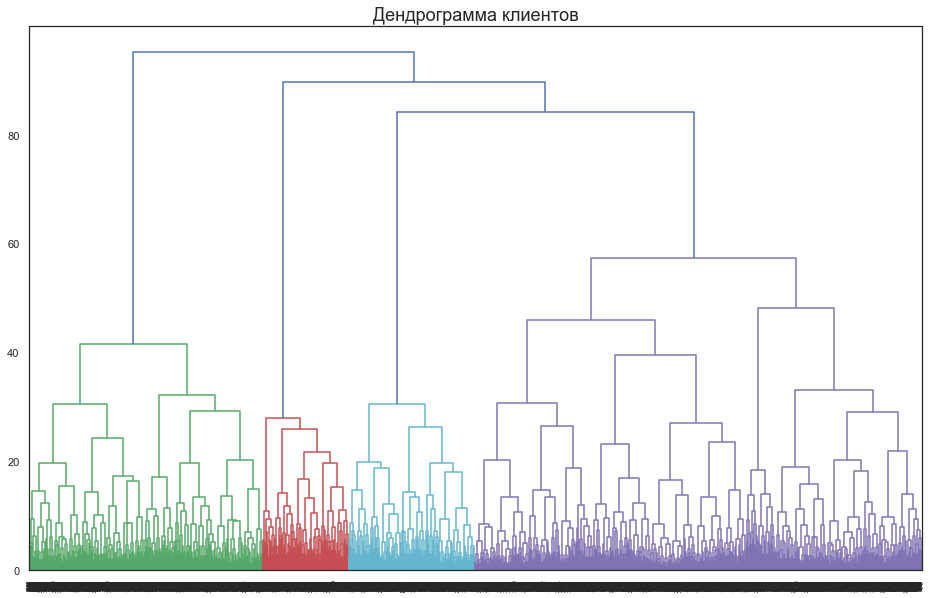

In [18]:
plt.figure(figsize=(16, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма клиентов', fontsize=18)
plt.show()

Нам предложено 4 кластера (4 цвета). Считаю, что лучше **5**, т.к. последний получился слишком обширным.  
Создадим столбец в нашей таблице с указанием кластера.

In [19]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_st)
df['cluster_km'] = labels

Теперь построим гистограммы с накоплением для распределения значений признаков по кластерам, чтобы найти отличия.  
Сначала не категориальные признаки.

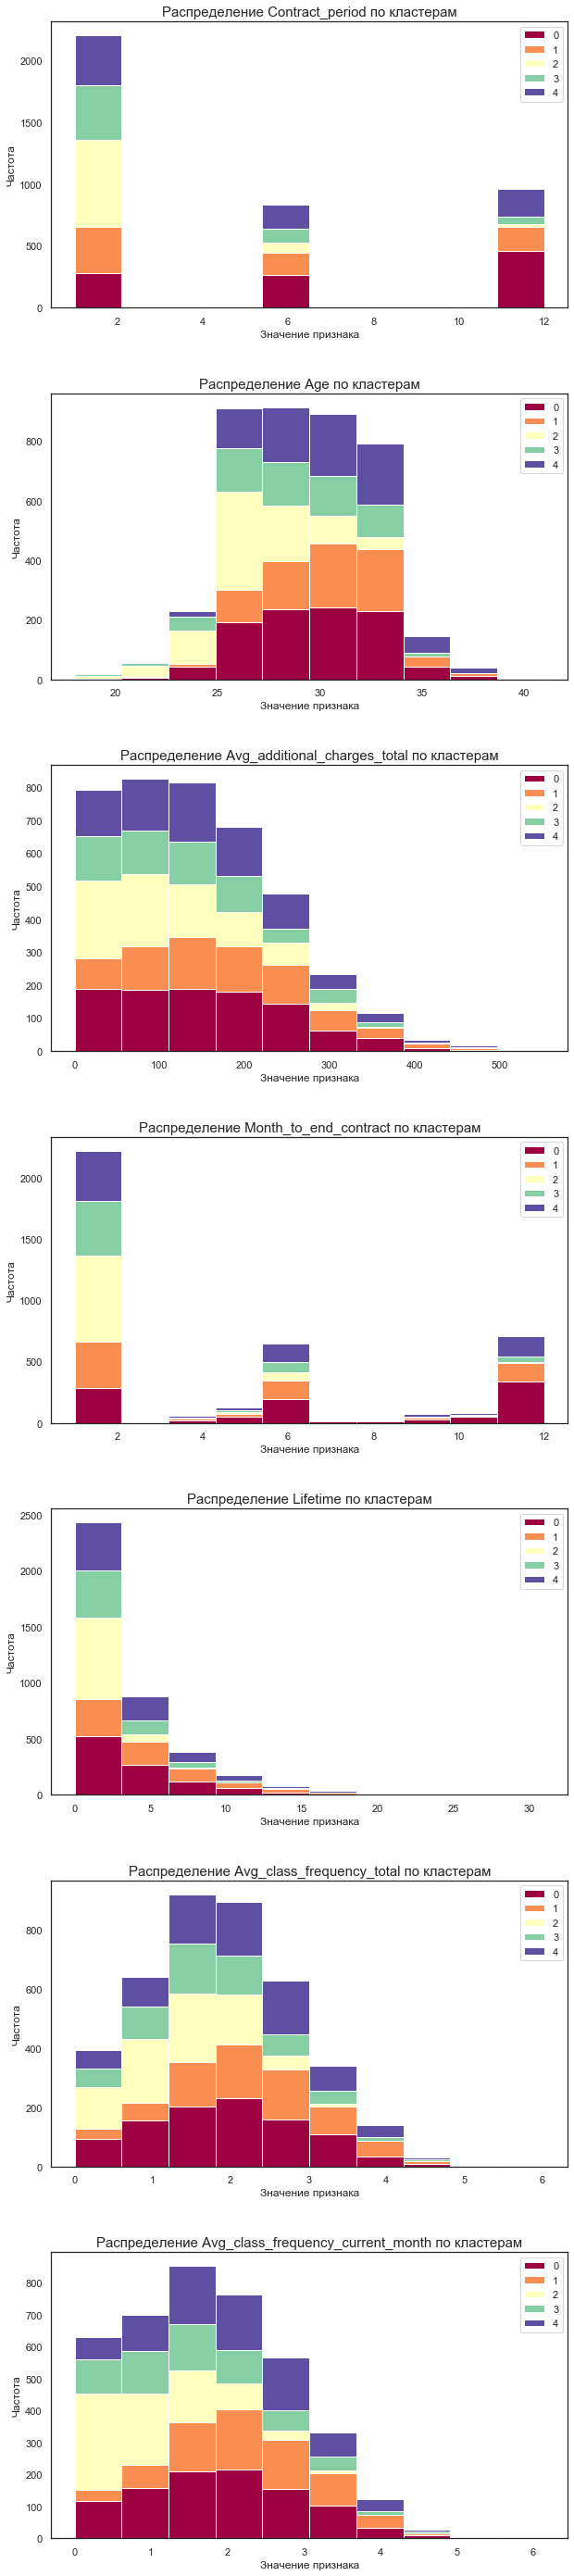

In [20]:
rows = len(a)
fig, axes = plt.subplots(rows, 1, figsize=(10, 50))
fig.subplots_adjust(hspace=0.3)

for row in range(rows):
    feature = a[row]
    df_agg = df.loc[:, ['cluster_km', feature]].groupby('cluster_km')
    values = [df[feature].values.tolist() for i, df in df_agg]
    colors = [plt.cm.Spectral(i/float(len(values)-1)) for i in range(len(values))]
        
    n, bins, patches = axes[row].hist(values, stacked=True, density=False, color=colors[:len(values)])
    axes[row].legend({group:col for group, col in zip(np.unique(df['cluster_km']).tolist(), colors[:len(values)])})
    axes[row].set_title('Распределение {} по кластерам'.format(feature), fontsize=15)
    axes[row].set_ylabel('Частота', fontsize=12)
    axes[row].set_xlabel('Значение признака', fontsize=12)

По распределению не категориальных признаков можно сказать следующее:

- **Срок контракта и взаимодействия с фитнес-центром**:

    - кластеры **`0`**, **`1`** и **`4`** почти одинаково часто заключают контракты на срок 1, 6 и 12 месяцев, но кластер **`0`** чаще на 12 месяцев, а кластеры **`1`** и **`4`** чаще на 1 месяц. Соответственно чаще перестают посещать тренировки когда до конца котракта остаётся - 12 месяцев для кластера **`0`** и 1 месяц для кластеров **`1`** и **`4`**;
    
    - чаще всего заключают контракт на 1 месяц, и чаще всего перестают посещать тренировки, когда до конца контракта остаётся 1 месяц - кластеры **`2`** и **`3`**;

- **Возраст**:

    - распреление выглядит равномерным, но кажется, что кластер **`2`** моложе остальных;

- **Доп. расходы**:

    - сложно сказать, но создаётся ощущение, что лидирует кластер **`4`** а меньше других потратил кластер **`2`**;

- **Среднее количество тренировок в неделю**:

    - Распределение в целом равномерное, но видно, что кластер **`2`** посещает тренировки реже остальных;

Теперь проделаем то же самое для категориальных признаков.

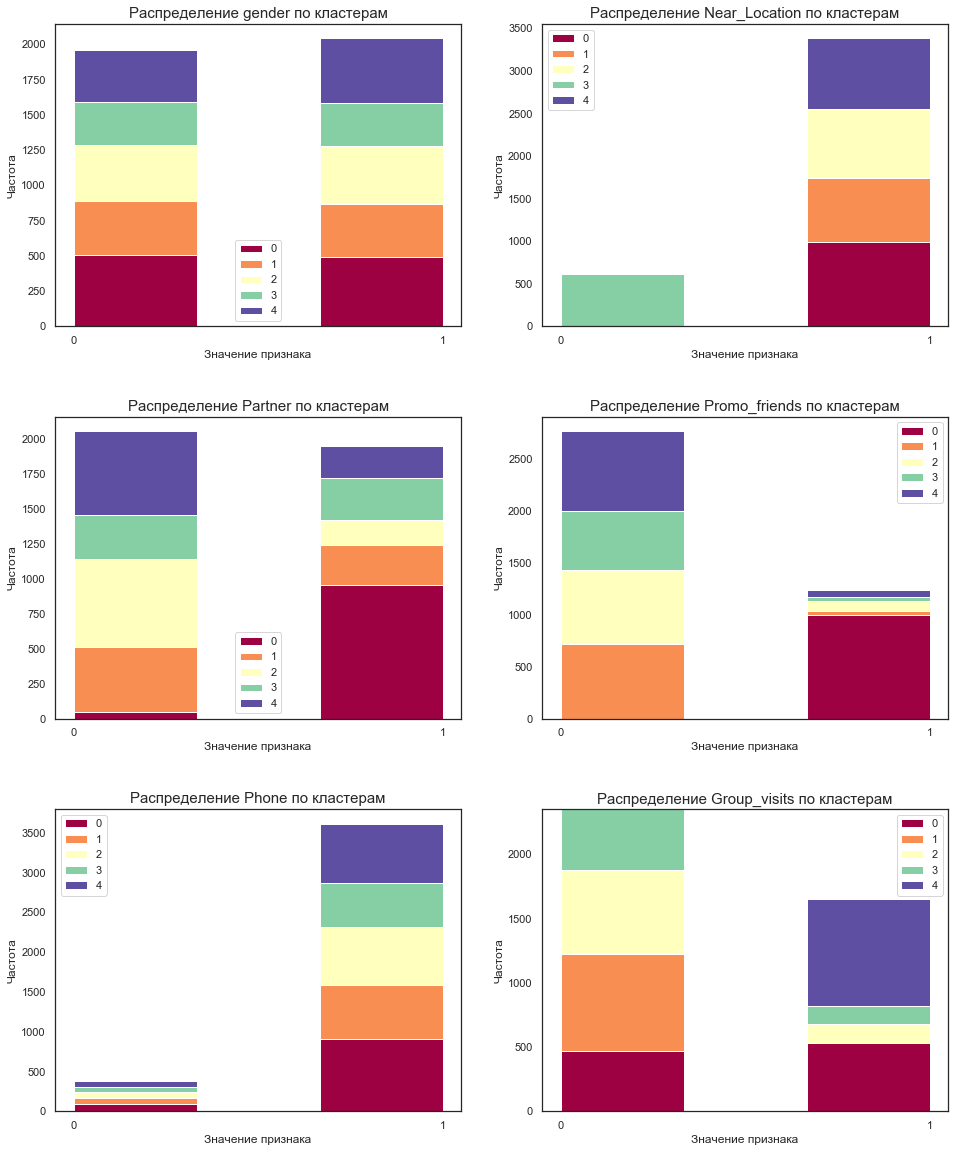

In [21]:
rows = 3
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 20))
fig.subplots_adjust(hspace=0.3)
counter = 0

for row in range(rows):
    for col in range(cols):
        feature = b[counter]
        df_agg = df.loc[:, ['cluster_km', feature]].groupby('cluster_km')
        values = [df[feature].values.tolist() for i, df in df_agg]
        colors = [plt.cm.Spectral(i/float(len(values)-1)) for i in range(len(values))]

        n, bins, patches = axes[row,col].hist(values, bins=3, stacked=True, density=False, color=colors[:len(values)])
        axes[row,col].legend({group:col for group, col in zip(np.unique(df['cluster_km']).tolist(), colors[:len(values)])})
        axes[row,col].set_title('Распределение {} по кластерам'.format(feature), fontsize=15)
        axes[row,col].set_ylabel('Частота', fontsize=12)
        axes[row,col].set_xlabel('Значение признака', fontsize=12)
        axes[row,col].set_xticks([0, 1])
        counter += 1

Выводы по графикам:
- Пол распределён равномерно.
- Удобное расположение фитнес-центра актуально для всех клиентов всех кластеров, кроме кластера **`3`** Там в удобство не попал никто.
- Клиенты в большинстве кластеров реже являются сотрудниками компании-партнёра, но в кластере **`0`** такие почти все, а в кластере **`3`**, примерно 50/50.
- Весь кластер **`0`** участвовал в промо-акциях, в то время как в других кластерах участвовала лишь малая часть. 
- Нет номеров телефонов для очень малой части клиетов каждого кластера.
- Посещение групповых тренировок - весь кластер **`4`**, кластер **`0`** - примерно 50/50, кластер **`1`** вообще нет, кластеры **`2`** и **`3`** - малая часть.

И обязательно посмотрим на кластеры с точки зрения оттока.

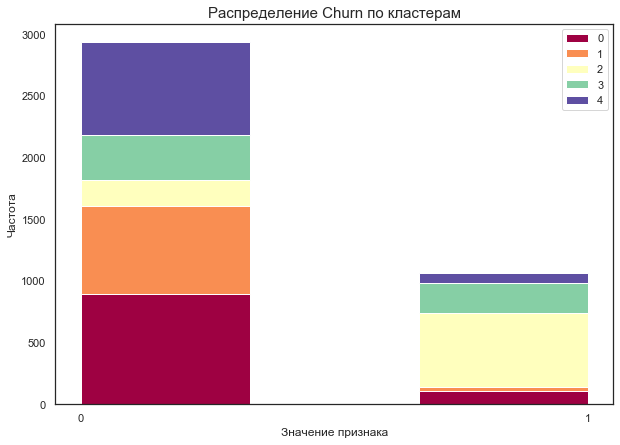

In [22]:
plt.figure(figsize=(10, 7))
df_agg = df.loc[:, ['cluster_km', 'Churn']].groupby('cluster_km')
values = [df['Churn'].values.tolist() for i, df in df_agg]
colors = [plt.cm.Spectral(i/float(len(values)-1)) for i in range(len(values))]

n, bins, patches = plt.hist(values, bins=3, stacked=True, density=False, color=colors[:len(values)])
plt.legend({group:col for group, col in zip(np.unique(df['cluster_km']).tolist(), colors[:len(values)])})
plt.title('Распределение Churn по кластерам', fontsize=15)
plt.ylabel('Частота', fontsize=12)
plt.xlabel('Значение признака', fontsize=12)
plt.xticks([0, 1])
plt.show()

Большая часть ушедших - кластер **`2`**, только небольшая его часть осталась.  
В других кластерах ушла лишь малая часть, только в кластере **`3`** почти поровну.

Дополнительно посмотрим на средние значения показателей для каждого кластера.

In [23]:
display(df.groupby('cluster_km').agg('mean'))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.492000,0.994000,0.953000,1.000000,0.906000,7.346000,0.528000,29.633000,154.086252,6.730000,4.287000,1.960141,1.919105,0.108000
1,0.495352,0.998672,0.378486,0.046481,0.903054,5.059761,0.000000,30.342629,174.392898,4.698539,5.166003,2.240956,2.237272,0.046481
2,0.510507,1.000000,0.224969,0.114957,0.899876,1.797281,0.187886,26.800989,111.061687,1.710754,1.422744,1.330053,0.984420,0.740420
3,0.502455,0.000000,0.489362,0.072013,0.913257,2.996727,0.232406,28.700491,137.375245,2.826514,3.027823,1.768079,1.599583,0.400982
4,0.551391,0.998791,0.275695,0.074970,0.897219,5.180169,1.000000,30.275695,155.484435,4.730351,4.499395,2.070362,2.044372,0.089480


Самая высокая доля оттока в кластере **`2`**, самая низкая в кластере **`1`**.

Кластер **`2`** - всегда удобное местонахождение; реже других являются сотрудниками компании-партнёра; очень мало промо-акций (видимо, нет знакомых, которые могли бы подарить); редко посещают групповые тренировки; меньше остальных покупают дополнительные услуги; тренируются, примерно, 1 раз в неделю.

Кластер **`1`** во многом похож на кластер **`2`**, существенные отличия в том, что его "члены" покупают контракт на более долгий срок; они немного старше своих "коллег" из кластера **`2`**; тратят больше денег на доп. услуги; дольше посещают клуб и занимаются по 2 раза в неделю. 

## Шаг 5. Выводы и рекомендации по работе с клиентами

### Большая часть оттока, это клиенты, которые приобрели краткосрочный контракт.
Имеет смысл отказаться от краткосрочных контрактов. Например, минимальный контракт должен быть на 6 месяцев. Или сделать стоимость краскосрочных контрактов явно невыгодной, чтобы мотивировать клиентов покупать более длительные, тогда у клиентов будет больше мотивации заниматься. А если не будет - клуб заработает больше денег на продаже контракта ничего не отдавая взамен.

### Большая часть ушедших не регулярно посещала тренировки.
Необходимо стимулировать клиентов чаще посещать спортзал. С одной стороны, так это быстрее войдёт в привычку; с другой стороны, у клиента быстреее появятся результаты и желание их развивать. Например, для потенциальных "беглецов" можно устраивать акции - "Если придёте 3 раза на следующей неделе, получите фирменную футболку. А если ещё 3 раза, баночку протеина".

### Ушедшие клиенты быстро теряли интерес.
Те, кто тренируется дольше времени, уходят гораздо реже. Самое опасное время - первые недели. Стоит попробовать стимулировать клиентов в это время, когда они только начинают свой "путь". Помочь им удержать фокус на тренировках, чтобы они успели втянуться и уже не хотели уходить из зала и терять форму. Например, при регулярных тренировках в первые 2 недели - в подарок индивидуальная тренировка с инструктором, который составит программу и/или диету. Следующую индивидуальную тренировку он уже купит самостоятельно. А как показывают графики, те кто больше тратит в клубе, остаются в нём дольше. 

<font FACE='Courier' size=3><b>Анализ проведён на основе данных фитнес-центра о клиентах за месяц, предшествующий проверке факта оттока, информации из журнала посещений, покупок, а так же данных о текущем статусе абонемента.</b></font>